- https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr16/visit/apo25m/K21_071+10/7561/57294/
- https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr16/exposures/apogee-n/57294/

in the ap1D: row = 300-fiberid


NOTE: data model is slightly wrong! have OBJECT

In [125]:
import os
from pathlib import Path
import requests

from astropy.constants import c
import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy.nddata import StdDevUncertainty
from specutils.spectra import Spectrum1D

In [147]:
name = '2M19241171+3650235'

In [ ]:
allvisit = at.Table.read('/Users/apricewhelan/data/

In [129]:
root_url = "https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr16/visit/apo25m/K21_071+10/7561/57294/"
# sub_path = f"{r['TELESCOPE']}/{r['FIELD'].strip()}"

hduls = {}

for num in np.arange(33, 42+1):
    filename = f'apCframe-a-173200{num:02d}.fits'
    url = os.path.join(root_url, filename)
    local_path = Path('../data') / filename
    if not local_path.exists():
        print(f"downloading {filename}...")
        r = requests.get(url, auth=('sdss', '2.5-meters!'))
        with open(local_path, 'wb') as f:
            f.write(r.content)

    hduls[num] = fits.open(local_path)

downloading apCframe-a-17320035.fits...
downloading apCframe-a-17320036.fits...
downloading apCframe-a-17320037.fits...
downloading apCframe-a-17320038.fits...
downloading apCframe-a-17320039.fits...
downloading apCframe-a-17320040.fits...
downloading apCframe-a-17320041.fits...
downloading apCframe-a-17320042.fits...


In [130]:
def get_spectrum(hdulist):
    object_idx, = np.where(hdul[11].data['OBJECT'] == name)[0]

    flux = hdul[1].data[object_idx]
    flux_err = hdul[2].data[object_idx]
    wvln = hdul[4].data[object_idx]
    
    unc = StdDevUncertainty(flux_err)
    spectrum = Spectrum1D(flux=flux*u.one,
                          spectral_axis=wvln*u.angstrom, 
                          uncertainty=unc)
    
    return spectrum

In [131]:
spectra = {}
for k, hdul in hduls.items():
    spectra[k] = get_spectrum(hdul)

(0.0, 8000.0)

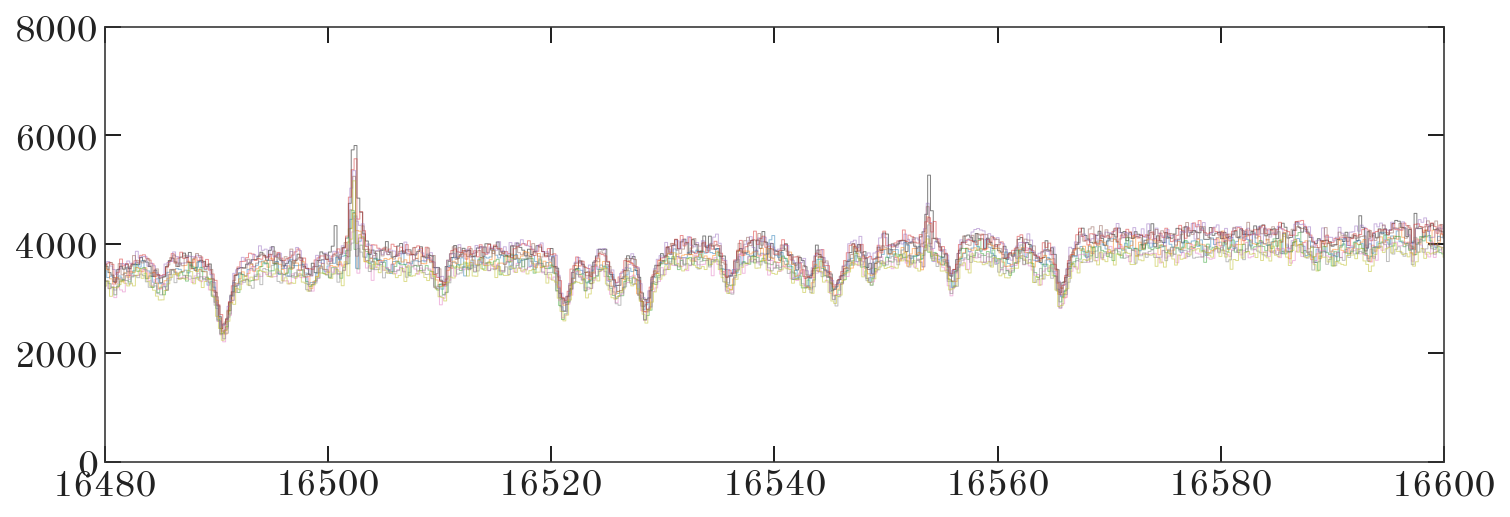

In [134]:
plt.figure(figsize=(12, 4))

for s in spectra.values():
    plt.plot(s.wavelength, s.flux, 
             marker='', ls='-', lw=0.5,
             drawstyle='steps-mid', alpha=0.5)
plt.xlim(16480, 16600)
plt.ylim(0, 8000)

In [75]:
rv_shift = ((1*u.km/u.s) / c * 16500*u.angstrom).to(u.angstrom)

In [73]:
pix_scale = 0.236*u.angstrom / u.pixel

In [74]:
rv_shift / pix_scale

<Quantity 6.99636556 pix>

Idea: fit the FWHM of a single line for each exposure

In [135]:
from astropy.modeling import models
from specutils.fitting import fit_lines

(1800.0, 5000.0)

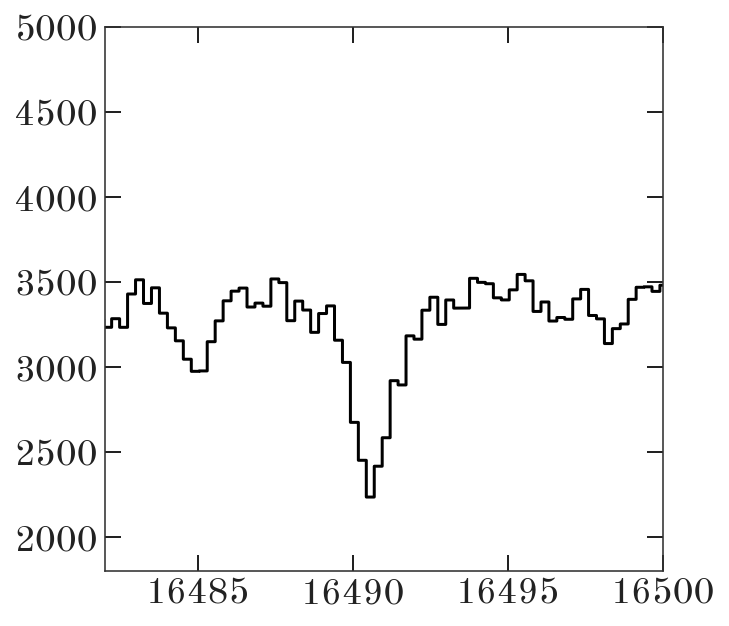

In [136]:
plt.figure(figsize=(5, 5))
plt.plot(s.wavelength, s.flux, 
         marker='', ls='-', 
         drawstyle='steps-mid')
plt.xlim(16482, 16500)
plt.ylim(1800, 5000)

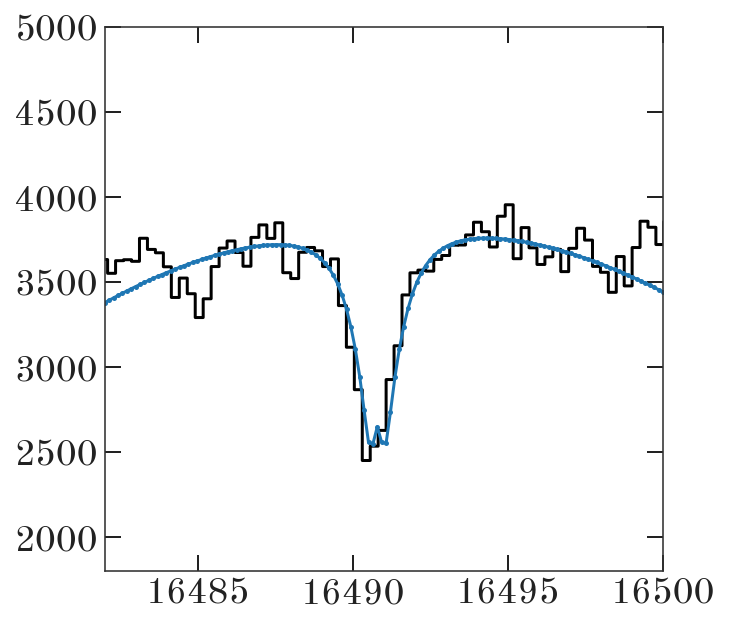

In [146]:
# Fit the spectrum
line = models.Voigt1D(amplitude_L=-1e3, 
                      x_0=16491, 
                      fwhm_L=1.,
                      fwhm_G=1.)
# bg = models.Linear1D(slope=1e-5,
#                      intercept=3500.)
bg = models.Polynomial1D(degree=3, c0=3500, c1=1e-5, c2=1e-5)
g = line + bg

fitted = []
for s in spectra.values():
    g_fit = fit_lines(s, g, 
                      window=(16487*u.angstrom, 16497*u.angstrom))
    fitted.append(g_fit)
    
    plt.figure(figsize=(5, 5))
    plt.plot(s.wavelength, s.flux, marker='', ls='-', 
             drawstyle='steps-mid')

    xx = np.linspace(16482, 16500, 128)
    plt.plot(xx, g_fit(xx*u.angstrom))

    plt.xlim(16482, 16500)
    plt.ylim(1800, 5000)
    
    break

- spline interpolate combined spectrum onto cFrame wvln grid
- then interpolate it again with a velocity shift
- 5 copies

c / 2 / instrument resolution to oversample the velocity shifts

In [145]:
# [model.fwhm_G_0 for model in fitted]
# [model.fwhm_L_0 for model in fitted]